In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse


In [3]:
torch.set_num_threads(30)

### 导入数据集

In [4]:
input_path = "../../appeal/sciCAR_cellline/"
output_path = "../../appeal/sciCAR_cellline/scMVP_output"

sciCAR_cellline_dataset = {
                "gene_names": 'sciCAR_cellline_scale_gene.txt',
                "gene_expression": 'sciCAR_cellline_rna_normalize_count.mtx',
                "gene_barcodes": 'sciCAR_cellline_cell_barcode.txt',
                "atac_names": 'sciCAR_cellline_peak.txt',
                "atac_expression": 'sciCAR_cellline_atac_normalize_count.mtx',
                "atac_barcodes": 'sciCAR_cellline_cell_barcode.txt'
                }
#cell_embeddings = pd.read_csv(input_path+'sciCAR_cellline_wnn_output.txt', sep="\t",index_col=None).iloc[:,[0,11]]
dataset = LoadData(dataset=sciCAR_cellline_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2021-07-08 17:29:03,958] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-07-08 17:29:10,537] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-07-08 17:29:10,749] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-07-08 17:29:10,750] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-07-08 17:29:11,949] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-07-08 17:29:12,052] INFO - scMVP.dataset.dataset | Downsampled from 4316 to 4316 cells


In [5]:
dataset = LoadData(dataset=sciCAR_cellline_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

atac_dataset = GeneExpressionDataset()
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
atac_dataset.populate_from_data(
    X=dataset.atac_expression, # notice the normalization
    batch_indices=None,
    gene_names=dataset.atac_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=[],
)
rna_dataset = GeneExpressionDataset()
Ys = []
measurement = CellMeasurement(
        name="atac_expression",
        data=atac_dataset.X,
        columns_attr_name="atac_names",
        columns=atac_dataset.gene_names,
    )
Ys.append(measurement)
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
rna_dataset.populate_from_data(
    X=dataset.X,
    batch_indices=None,
    gene_names=dataset.gene_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=Ys,
)
lr = 5e-3
use_batches = False
use_cuda = True
n_centroids = 15
n_alfa = 1.0


[2021-07-08 17:29:20,383] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-07-08 17:29:26,508] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-07-08 17:29:26,781] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-07-08 17:29:26,782] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-07-08 17:29:28,317] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-07-08 17:29:28,433] INFO - scMVP.dataset.dataset | Downsampled from 4316 to 4316 cells
[2021-07-08 17:29:30,032] WARNING - scMVP.dataset.dataset | This dataset has some empty cells, this might fail scMVP inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2021-07-08 17:29:30,082] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-07-08 17:29:30,086] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-07-08 17:29:30,200] INFO - scMVP.dataset.dataset | Remapping

### 进行ATAC预训练


pre_atac_vae = VAE_Peak_SelfAttention(atac_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_atac_trainer = UnsupervisedTrainer(
    pre_atac_vae,
    atac_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

pre_atac_trainer.train(n_epochs=20, lr=lr)
torch.save(pre_atac_trainer.model.state_dict(), '{}/pre_atac_trainer.pkl'.format(output_path))
pre_atac_trainer.model.eval()


##### 对atac进行可视化


full = pre_atac_trainer.create_posterior(pre_atac_trainer.model, atac_dataset, indices=np.arange(len(atac_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
prior_adata = anndata.AnnData(X=atac_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))

sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()
# save data as csv file
df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=atac_dataset.barcodes )
df.insert(0,"labels",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"scmvp_atac_umap.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=atac_dataset.barcodes)
df.to_csv(os.path.join(output_path,"scmvp_latent_atac_imputation.csv"))

### 进行RNA预训练


pre_vae = VAE_Attention(rna_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)
pre_trainer.train(n_epochs=10, lr=lr)
torch.save(pre_trainer.model.state_dict(), '{}/pre_trainer.pkl'.format(output_path))
pre_trainer.model.eval()




# RNA pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, rna_dataset, indices=np.arange(len(rna_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

df = pd.DataFrame(data=imputed_values.T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
# visulization
prior_adata = anndata.AnnData(X=rna_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# save data as csv file
df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=rna_dataset.barcodes )
df.insert(0,"labels",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"scmvp_rna_umap.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=rna_dataset.barcodes)
df.to_csv(os.path.join(output_path,"scmvp_rna_latent_imputation.csv"))


In [6]:

# Reload pretrainer for multiVAE
# pre_trainer = UnsupervisedTrainer(
#     pre_vae,
#     rna_dataset,
#     train_size=0.9,
#     use_cuda=use_cuda,
#     frequency=5,
# )
# pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer.pkl' % output_path))

# pre_atac_trainer = UnsupervisedTrainer(
#     pre_atac_vae,
#     atac_dataset,
#     train_size=0.9,
#     use_cuda=use_cuda,
#     frequency=5,
# )
# pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer.pkl' % output_path))

#n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))
n_centroids=9

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(rna_dataset.nb_genes, len(rna_dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)
#trainer.model.init_gmm_params_with_louvain(latent,np.array(prior_adata.obs['louvain'].tolist()).astype(int))

# trainer.model.RNA_encoder.load_state_dict(pre_trainer.model.z_encoder.state_dict())
# for param in trainer.model.RNA_encoder.parameters():
#     param.requires_grad = True
# trainer.model.ATAC_encoder.load_state_dict(pre_atac_trainer.model.z_encoder.state_dict())
# for param in trainer.model.ATAC_encoder.parameters():
#     param.requires_grad = True

if os.path.exists("{}/multi_vae_trainer.pkl".format(output_path)):
    trainer.model.load_state_dict(torch.load("{}/multi_vae_trainer.pkl".format(output_path)))
else:
    trainer.train(n_epochs=20, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer.pkl' % output_path)

... storing 'cell_type' as categorical


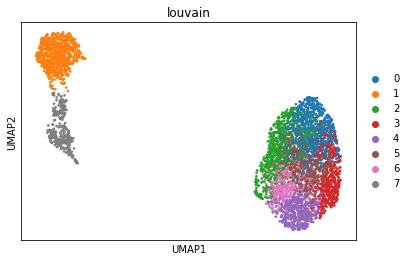

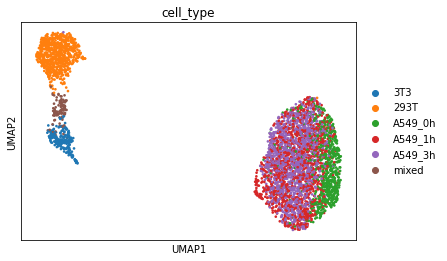

... storing 'kmeans' as categorical


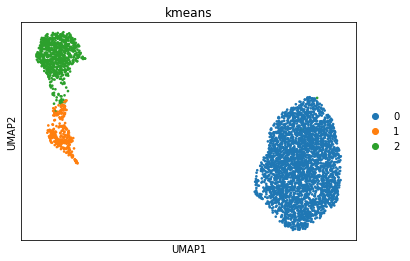

In [35]:
# 进行multi vae可视化
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
# visulization
prior_adata = anndata.AnnData(X=latent)
cell_embeddings = pd.read_csv(input_path+'sciCAR_cell_annot.txt', sep="\t",index_col=0).iloc[:,[3,4,5]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
prior_adata.obsm["X_multi_vi"] = latent


sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()


sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

# 用kmeans做可视化
from sklearn.cluster import KMeans
latent_code = prior_adata.obsm["X_multi_vi"]

kmeans = KMeans(n_clusters=3, random_state=0).fit(latent_code) 
prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(prior_adata, color=['kmeans'])
plt.show()


In [36]:
# Differential gene analysis
posterior_adata = anndata.AnnData(X=imputed_values[0])
posterior_adata.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] =  cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
sc.tl.rank_genes_groups(posterior_adata, 'cell_type', group=["A549_1h","A549_3h"],reference="A549_0h")
df_tab=sc.get.rank_genes_groups_df(posterior_adata, group=["A549_1h","A549_3h"])
df_tab.to_csv("{}/sciCAR_A549_DEG.csv".format(output_path),index=False)

... storing 'cell_type' as categorical


In [33]:

# save file
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=rna_dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=rna_dataset.barcodes)
df.insert(0,"kmeans",prior_adata.obs['kmeans'].values)
df.to_csv(os.path.join(output_path,"multivae_umap.csv"))

df = pd.DataFrame(data=imputed_values[1].T, columns=rna_dataset.barcodes, index=rna_dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation.csv"))

df = pd.DataFrame(data=imputed_values[0].T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
df.to_csv(os.path.join(output_path,"gene_multivae_imputation.csv"))

In [37]:
# compute raw data DEG
raw_data = anndata.AnnData(X=dataset.X)
raw_data.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
raw_data.obsm["X_multi_vi"] = latent
raw_data.obs['cell_type'] = cell_embeddings["labels"].to_list()
sc.tl.rank_genes_groups(raw_data, 'cell_type', group=["A549_1h","A549_3h"],reference="A549_0h")
df_tab=sc.get.rank_genes_groups_df(raw_data, group=["A549_1h","A549_3h"])
df_tab.to_csv("{}/sciCAR_A549_raw_DEG.csv".format(output_path),index=False)

... storing 'cell_type' as categorical
